# **Multilabel Classification**

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/>

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

# **Setting Up**

In [7]:
!nvidia-smi

Thu Oct 30 14:38:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
%matplotlib inline

In [9]:
! pip install -q transformers[sentencepiece] fastbook fastai nbdev plum-dispatch evaluate seqeval

In [10]:
!git clone https://github.com/msi1427/blurr.git
%cd blurr

fatal: destination path 'blurr' already exists and is not an empty directory.
/content/blurr/blurr


In [11]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from google.colab import drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
%cd /content/drive/MyDrive/MultiLabel_DataScience_Tags_Classification

/content/drive/MyDrive/MultiLabel_DataScience_Tags_Classification


# **Data**

In [14]:
df = pd.read_csv("data/scraped/ques_details.csv")
df.head()

,title,description,tags,url
0,How to find significance for Gini coefficient changes?,"I'm using the Gini coefficient to evaluate the performance of a model. Making some changes (feature selection, hyperparameter tuning, etc.) I created variant models with different Gini coefficients.\nHow can I prove that the improvement in the Gini coefficient is indeed statistically significant?","['statistics', 'model-selection', 'gini-index']",https://datascience.stackexchange.com/questions/114955/how-to-find-significance-for-gini-coefficient-changes
1,How does batch normalization make a model less sensitive to hyperparameter tuning?,"Question 22 of 100+ Data Science Interview Questions and Answers for 2022 asks What is the benefit of batch normalization?\nThe first bullet of the answers to this is The model is less sensitive to hyperparameter tuning.\nThe wikipedia page batch normalization similarly claims:\nFurthermore, batch normalization seems to have a regularizing effect such that the network improves its generalization properties, and it is thus unnecessary to use dropout to mitigate overfitting.\nIn both cases I suspect they are referring to improved test error, with the former involving improved test error even...","['hyperparameter-tuning', 'batch-normalization', 'generalization']",https://datascience.stackexchange.com/questions/114953/how-does-batch-normalization-make-a-model-less-sensitive-to-hyperparameter-tunin
2,Time series data for Prophet model,"I have a time series data that has some missing dates. For example, in the dataset below '2017-08-06' is missing.\nTo enter this data in the Prophet model, do I have to create the data frame with all the missing dates? I know the Prophet model does not require the missing data for any specific time to be filled as it is a curve-fitting-based model. But I am unsure if all dates should be included for daily time series prediction. Thanks so much for answering my question.",['time-series'],https://datascience.stackexchange.com/questions/114950/time-series-data-for-prophet-model
3,Algorithm suggestion for correlated models,"I'm looking for suggestions on how to proceed with predicting on separate but correlated models.\nThe example I will use is housing data. I have three inputs:\nLatitude\nLongitude\n1-Google Street View Image\nI want to create models that predict things like:\nSquare Footage (regression)\nHome Price (regression)\nNumber of Floors (categorical)\nFor Sale or Not (binary)\nThe dataset is supervised, so we are given 7 features. The model in production will only have 3 inputs (lat, long, image). Ideally, we could solve this dependence by using 6 input features for every model, but production wil...",['model-selection'],https://datascience.stackexchange.com/questions/114948/algorithm-suggestion-for-correlated-models
4,How many matrix combinations is this? [closed],"Closed. This question is off-topic. It is not currently accepting answers.\nThis question does not appear to be about data science, within the scope defined in the help center.\nClosed 2 years ago.\nImprove this question\nInput Matrix:\n A B C D E \nA 1 - - - -\nB - 1 - - -\nC - - 1 - -\nD - - - 1 -\nE - - - - 1\n""-"": arbritary values\n""1"": locked ""1"" value (diagonally locked, ref below)\nOutput Matrix (one possible example after some arbitrary optimization based on the arbitrary values in the matrix):\n C E A D B \nC 1 - - - -\nE - 1 - - -\nA - - 1 - -\nD - - - 1 -\nB - - - - 1\nSidenot...",['matrix'],https://datascience.stackexchange.com/questions/114947/how-many-matrix-combinations-is-this


In [15]:
df.shape

(24500, 4)

In [16]:
df = df.dropna().reset_index(drop=True)
df.shape

(24500, 4)

**Extracting and Counting Unique Tags from Dataset**

In [17]:
tags_list = df.tags.to_list()
tag_count = {}
for tags in tags_list:
  tag_list = eval(tags)
  for tag in tag_list:
    if tag in tag_count.keys():
      tag_count[tag] += 1
    else:
      tag_count[tag] = 1
print(f"Number of Tags: {len(tag_count)}")
print(tag_count)

Number of Tags: 692
{'statistics': 744, 'model-selection': 170, 'gini-index': 2, 'hyperparameter-tuning': 172, 'batch-normalization': 43, 'generalization': 28, 'time-series': 1273, 'matrix': 43, 'python': 4414, 'predictive-modeling': 779, 'feature-engineering': 420, 'classification': 2262, 'binary-classification': 103, 'shap': 53, 'neural-network': 2964, 'rnn': 490, 'pytorch': 461, 'preprocessing': 361, 'machine-learning': 7629, 'svm': 405, 'linear-algebra': 60, 'vector-space-models': 28, 'nlp': 1776, 'text-generation': 57, 'tokenization': 47, 'decision-trees': 491, 'vc-theory': 18, 'pac-learning': 14, 'xgboost': 456, 'ensemble-modeling': 136, 'boosting': 76, 'multiclass-classification': 362, 'distribution': 103, 'lightgbm': 68, 'scikit-learn': 1554, 'logistic-regression': 448, 'regression': 1060, 'accuracy': 273, 'kernel': 61, 'seaborn': 56, 'transformer': 315, 'machine-translation': 57, 'huggingface': 62, 'dataset': 1041, 'active-learning': 22, 'deep-learning': 3209, 'clustering': 93

**Identifying Rare Tags**

In [18]:
threshold = int(len(df) * 0.001)
rare_tags = [key for key, value in tag_count.items() if value < threshold]
len(rare_tags), rare_tags[:5]

(393,
 ['gini-index', 'vc-theory', 'pac-learning', 'active-learning', 'annotation'])

**Cleaning Tag Lists by Removing Rare Tags**

In [19]:
tags_list = df.tags.to_list()
revised_tag_list = []
indices_to_drop = []

for idx, tags in enumerate(tags_list):
  tag_list = eval(tags)
  revised_tags = []

  for tag in tag_list:
    if tag not in rare_tags:
      revised_tags.append(tag)

  if len(revised_tags) == 0:
    indices_to_drop.append(idx)
  else:
    revised_tag_list.append(revised_tags)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(24340, 4)

In [20]:
df['revised_tags'] = revised_tag_list

In [21]:
df.tail()

,title,description,tags,url,revised_tags
24335,How to use TFIDF vectors with multinomial naive bayes?,"Say we have used the TFIDF transform to encode documents into continuous-valued features.\nHow would we now use this as input to a Naive Bayes classifier?\nBernoulli naive-bayes is out, because our features aren't binary anymore.\nSeems like we can't use Multinomial naive-bayes either, because the values are continuous rather than categorical.\nAs an alternative, would it be appropriate to use gaussian naive bayes instead? Are TFIDF vectors likely to hold up well under the gaussian-distribution assumption?\nThe sci-kit learn documentation for MultionomialNB suggests the following:\nThe mul...","['scikit-learn', 'naive-bayes-classifier', 'text']",https://datascience.stackexchange.com/questions/18140/how-to-use-tfidf-vectors-with-multinomial-naive-bayes,"[scikit-learn, naive-bayes-classifier, text]"
24336,Modeling the influence of events order on probability,"The case is to model if the sequence of events influences the probability of binary target variable. We have for example five different events which occur in time (event: A,B,C,D,E). They can occur in order from 1 to 5. I would like to check if the order of their occurrence influences the target variable.\nMy first idea was to convert the time of occurrence into numbers from 1 to 5 and then for example use logistic regression.\nDo You know any other practices? Any whitepapers and ideas will be helpful.","['data-mining', 'probability', 'sequence']",https://datascience.stackexchange.com/questions/18134/modeling-the-influence-of-events-order-on-probability,"[data-mining, probability, sequence]"
24337,what is the proper tool to analyse data and find trends in my case? [closed],"Closed. This question needs details or clarity. It is not currently accepting answers.\nWant to improve this question? As written, this question is lacking some of the information it needs to be answered. If the author adds details in comments, consider editing them into the question. Once there's sufficient detail to answer, vote to reopen the question.\nClosed 8 years ago.\nImprove this question\nI have a database of hundreds of thousands of loans. I want to find some trends in user behavior, not just some information regarding all loans together but I want to find something similar for ...","['data-mining', 'bigdata', 'data']",https://datascience.stackexchange.com/questions/18132/what-is-the-proper-tool-to-analyse-data-and-find-trends-in-my-case,"[data-mining, bigdata, data]"
24338,Does bias have multiple meanings in Data Science?,"What are the meanings of Bias?\nAnd is Under fitting, which is used in machine learning contexts, the same as ""Bias""?\nI have faced biased data in sampling in statistics but it seems this is a different thing to bias in learning concepts.\nI have heard that some data sets are biased, also have heard the model (for example neural network) has low bias or e.g. 'high bias' problem. Are these uses of bias different?",['machine-learning'],https://datascience.stackexchange.com/questions/18123/does-bias-have-multiple-meanings-in-data-science,[machine-learning]
24339,Compressing profiles with a large number of dimensions,"I 'think' this is a related question, but not sure how to apply it.\nI'm trying to build out a very crude recommendation system using Amazon ML, Facebook likes, and historical actions.\nSo lets say we have a number of users within a system that promotes products within several categories. To better predict which categories of items to present to the user, we will consider their past interactions with specific items, and the past interactions of other users who share a similar profile. The profile consisting of basically the users Facebook likes data and some demographic info.\nI'm unsure o...","['machine-learning', 'amazon-ml']",https://datascience.stackexchange.com/questions/18119/compressing-profiles-with-a-large-number-of-dimensions,[machine-learning]


In [22]:
revised_tags_list = df.revised_tags.to_list()
revised_tag_count = {}
for tags in revised_tags_list:
  tag_list = tags
  for tag in tag_list:
    if tag in revised_tag_count.keys():
      revised_tag_count[tag] += 1
    else:
      revised_tag_count[tag] = 1
print(f"Number of Tags: {len(revised_tag_count)}")
print(revised_tag_count)

Number of Tags: 299
{'statistics': 744, 'model-selection': 170, 'hyperparameter-tuning': 172, 'batch-normalization': 43, 'generalization': 28, 'time-series': 1273, 'matrix': 43, 'python': 4414, 'predictive-modeling': 779, 'feature-engineering': 420, 'classification': 2262, 'binary-classification': 103, 'shap': 53, 'neural-network': 2964, 'rnn': 490, 'pytorch': 461, 'preprocessing': 361, 'machine-learning': 7629, 'svm': 405, 'linear-algebra': 60, 'vector-space-models': 28, 'nlp': 1776, 'text-generation': 57, 'tokenization': 47, 'decision-trees': 491, 'xgboost': 456, 'ensemble-modeling': 136, 'boosting': 76, 'multiclass-classification': 362, 'distribution': 103, 'lightgbm': 68, 'scikit-learn': 1554, 'logistic-regression': 448, 'regression': 1060, 'accuracy': 273, 'kernel': 61, 'seaborn': 56, 'transformer': 315, 'machine-translation': 57, 'huggingface': 62, 'dataset': 1041, 'deep-learning': 3209, 'clustering': 934, 'recommender-system': 322, 'similarity': 197, 'distance': 104, 'one-hot-en

In [23]:
encode_tag_types = { key: idx for idx, (key, value) in enumerate(revised_tag_count.items())}
with open("deployment/tag_types_encoded.json", "w") as fp:
  json.dump(encode_tag_types, fp)

In [24]:
# We need this because for multilabel classification all tags have possibility to be present in the predictions
categorical_tag_list = []
revised_tags_list = df.revised_tags.to_list()

for revised_tags in revised_tags_list:
  categorical_list = [0] * len(encode_tag_types)
  for tag in revised_tags:
    tag_type_index = encode_tag_types[tag]
    categorical_list[tag_type_index] = 1
  categorical_tag_list.append(categorical_list)

categorical_tag_list[3][:23]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
df['tag_cat_list'] = categorical_tag_list
df.head()

,title,description,tags,url,revised_tags,tag_cat_list
0,How to find significance for Gini coefficient changes?,"I'm using the Gini coefficient to evaluate the performance of a model. Making some changes (feature selection, hyperparameter tuning, etc.) I created variant models with different Gini coefficients.\nHow can I prove that the improvement in the Gini coefficient is indeed statistically significant?","['statistics', 'model-selection', 'gini-index']",https://datascience.stackexchange.com/questions/114955/how-to-find-significance-for-gini-coefficient-changes,"[statistics, model-selection]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,How does batch normalization make a model less sensitive to hyperparameter tuning?,"Question 22 of 100+ Data Science Interview Questions and Answers for 2022 asks What is the benefit of batch normalization?\nThe first bullet of the answers to this is The model is less sensitive to hyperparameter tuning.\nThe wikipedia page batch normalization similarly claims:\nFurthermore, batch normalization seems to have a regularizing effect such that the network improves its generalization properties, and it is thus unnecessary to use dropout to mitigate overfitting.\nIn both cases I suspect they are referring to improved test error, with the former involving improved test error even...","['hyperparameter-tuning', 'batch-normalization', 'generalization']",https://datascience.stackexchange.com/questions/114953/how-does-batch-normalization-make-a-model-less-sensitive-to-hyperparameter-tunin,"[hyperparameter-tuning, batch-normalization, generalization]","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Time series data for Prophet model,"I have a time series data that has some missing dates. For example, in the dataset below '2017-08-06' is missing.\nTo enter this data in the Prophet model, do I have to create the data frame with all the missing dates? I know the Prophet model does not require the missing data for any specific time to be filled as it is a curve-fitting-based model. But I am unsure if all dates should be included for daily time series prediction. Thanks so much for answering my question.",['time-series'],https://datascience.stackexchange.com/questions/114950/time-series-data-for-prophet-model,[time-series],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,Algorithm suggestion for correlated models,"I'm looking for suggestions on how to proceed with predicting on separate but correlated models.\nThe example I will use is housing data. I have three inputs:\nLatitude\nLongitude\n1-Google Street View Image\nI want to create models that predict things like:\nSquare Footage (regression)\nHome Price (regression)\nNumber of Floors (categorical)\nFor Sale or Not (binary)\nThe dataset is supervised, so we are given 7 features. The model in production will only have 3 inputs (lat, long, image). Ideally, we could solve this dependence by using 6 input features for every model, but production wil...",['model-selection'],https://datascience.stackexchange.com/questions/114948/algorithm-suggestion-for-correlated-models,[model-selection],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# **Dataloaders and Modelling**

In [26]:
labels = list(encode_tag_types.keys())

In [27]:
model_name = "bert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('tag_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [29]:
dls = dblock.dataloaders(df, bs=16)
torch.save(dls, f"dataloaders/{model_name}/dls-multilabel-question-classifier.pkl")

In [30]:
dls.vocab

['statistics', 'model-selection', 'hyperparameter-tuning', 'batch-normalization', 'generalization', 'time-series', 'matrix', 'python', 'predictive-modeling', 'feature-engineering', 'classification', 'binary-classification', 'shap', 'neural-network', 'rnn', 'pytorch', 'preprocessing', 'machine-learning', 'svm', 'linear-algebra', 'vector-space-models', 'nlp', 'text-generation', 'tokenization', 'decision-trees', 'xgboost', 'ensemble-modeling', 'boosting', 'multiclass-classification', 'distribution', 'lightgbm', 'scikit-learn', 'logistic-regression', 'regression', 'accuracy', 'kernel', 'seaborn', 'transformer', 'machine-translation', 'huggingface', 'dataset', 'deep-learning', 'clustering', 'recommender-system', 'similarity', 'distance', 'one-hot-encoding', 'lstm', 'linear-regression', 'dummy-variables', 'gan', 'dbscan', 'feature-scaling', 'mse', 'data-analysis', 'pandas', 'feature-selection', 'image-classification', 'computer-vision', 'object-detection', 'outlier', 'tensorflow', 'cnn', 'se

In [31]:
doc(accuracy_multi)

In [32]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# **Stage - 0**

In [34]:
learner.freeze()

SuggestedLRs(slide=0.015848932787775993, valley=0.0003981071640737355)

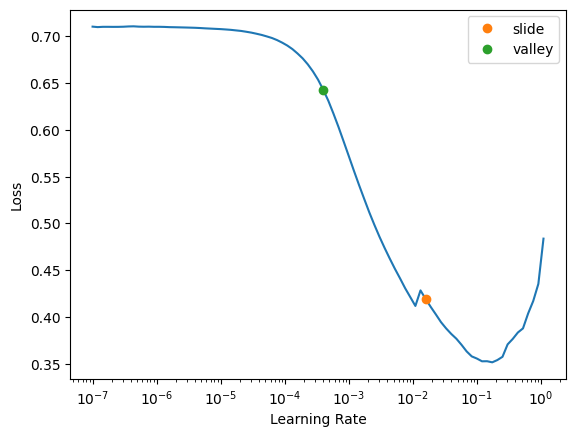

In [35]:
learner.lr_find(suggest_funcs=[slide, valley])

In [36]:
learner.fit_one_cycle(2,4e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.044690,0.044703,0.988818,03:20
1,0.043320,0.044135,0.988839,03:18


In [37]:
learner.save("question-classifier-stage-0")

Path('models/question-classifier-stage-0.pth')

# **Stage - 1**

In [38]:
learner.unfreeze()

SuggestedLRs(slide=0.0002290867705596611, valley=5.248074739938602e-05)

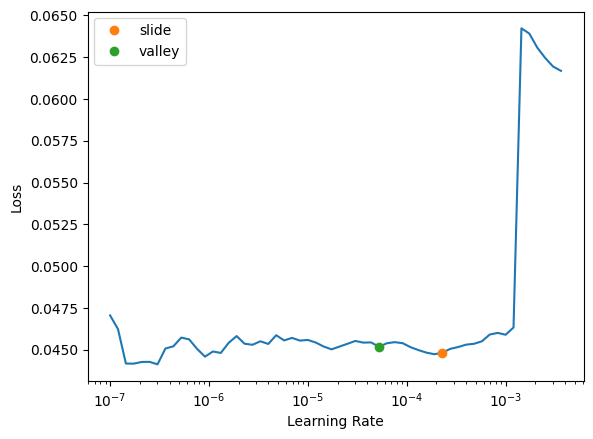

In [39]:
learner.lr_find(suggest_funcs=[slide, valley])

In [40]:
learner.fit_one_cycle(3, slice(5.3e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.036484,0.035827,0.987783,04:57
1,0.031386,0.030660,0.988266,04:55
2,0.027661,0.029480,0.988617,04:55


In [41]:
learner.save("question-classifier-stage-1")

Path('models/question-classifier-stage-1.pth')

In [42]:
learner.export(f"models/{model_name}/question-classifier-stage-1.pkl")